This practice comes from [#WOW2023 Week 19: Can you create a jitterfly chart? TC23 Live Edition](https://workout-wednesday.com/2023w19tab/), which creates a Jitterfly chart (Jitter & Butterfly). The main point is to add some jitter to the data in the scatter plot.

In [1]:
import pandas as pd
import numpy as np

In [2]:
file_path = '../data/central_trend_2017_base.xlsx'
genders = ['Males', 'Females']
primary_year = '2023'
secondary_year = '2011'

In [3]:
data = pd.read_excel(file_path, sheet_name=None)

In [4]:
data_selected = {}
for gender in genders:
    # Cut the age into discrete intervals
    bins = np.arange(0, data[f'Population - {gender}']['age'].max()+1, 10)
    bins[0] = -1
    labels = ['<=10' if age<10 else ('80+' if age>=80 else f'{age+1}-{age+10}') 
              for age in bins[:-1]]
    df = data[f'Population - {gender}']
    df['age_level'] = pd.cut(df['age'], bins=bins, labels=labels)
    df.columns = df.columns.astype('str')
    # Remove the items for London, which is the total population and duplicate.
    data_selected[gender] = df.query('district != "London"').groupby(['age_level', 'district']).sum(numeric_only=True)
    data_selected[f'{gender}_avg']  =data_selected[gender].groupby('age_level').mean(numeric_only=True)

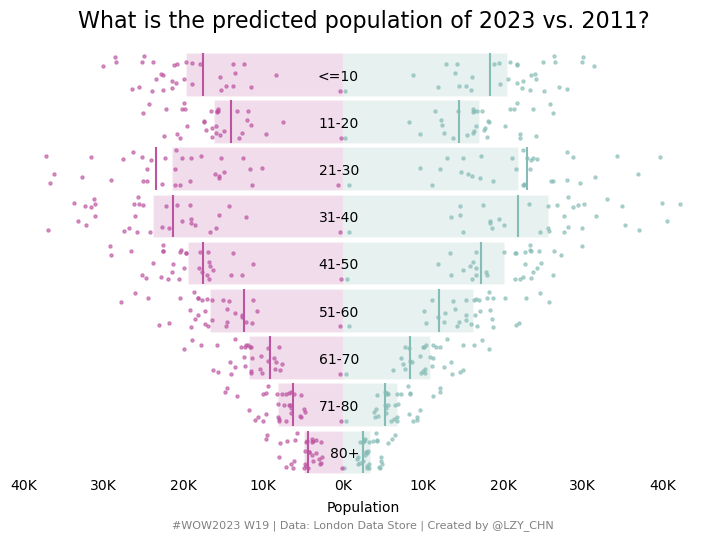

In [5]:
# First create the jitterfly chart by matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(9, 6))

colors = {'Males': '#86BCB6',
          'Females': '#BD54A1'}

bars = {}
points = {}

for gender in genders:
    # Add bar chart
    ys = data_selected[f'{gender}_avg'].index
    xs = data_selected[f'{gender}_avg'][primary_year]
    if gender == 'Females':
        xs = -xs
    bars[gender] = ax.barh(y=ys, width=xs, height=0.9,
                           color=colors[gender], ec='white', alpha=0.2)

    # Add some jitter to the scatter chart
    offset = 0.9
    bbox = bars[gender].patches[0].get_bbox()
    unique_districts = data_selected[f'{gender}'].reset_index()['district'].unique()
    jitter = pd.DataFrame({'district': unique_districts,
                           'jitter': np.random.default_rng(123).uniform(
                               offset*bbox.ymin, offset*bbox.ymax, len(unique_districts))})
    
    df = data_selected[f'{gender}'].reset_index().merge(jitter, on='district')
    age_level = df['age_level'].unique()
    age_pos = pd.DataFrame({'age_level': age_level,
                            'age_pos': np.arange(0, len(age_level))})
    df = df.merge(age_pos, on='age_level')
    xs = df[primary_year]
    ys = df['age_pos'] + df['jitter']
    if gender == 'Females':
        xs = -xs
    points[gender] = ax.scatter(x=xs, y=ys, s=5, c=colors[gender], alpha=0.6)
    
    # Add average population for the secondary year
    ymin, ymax = zip(*[(p.get_bbox().ymin, p.get_bbox().ymax) for p in bars[gender].patches])
    xs = data_selected[f'{gender}_avg'][secondary_year]
    if gender == 'Females':
        xs = -xs
    ax.vlines(xs, ymin, ymax, colors=colors[gender])
    
ax.invert_yaxis()
ax.spines['left'].set_position(('data', 0))
ax.spines[:].set_visible(False)
ax.tick_params(left=False, pad=-15, bottom=False)
ax.xaxis.set_major_formatter(lambda x, pos: f'{abs(x)/1000:.0f}K')
ax.set_xlabel('Population')

ax.annotate('What is the predicted population of 2023 vs. 2011?', 
            xy=(0.5, 1), xycoords='axes fraction',
            ha='center', va='bottom', fontsize=16)
ax.annotate('#WOW2023 W19 | Data: London Data Store | Created by @LZY_CHN',
            xy=(0.5, 0), xytext=(0, -18), xycoords='axes fraction', textcoords='offset points',
            ha='center', va='top', fontsize=8, color='gray');

In [6]:
# Another try with seaborn
import seaborn.objects as so

data_so_males = data_selected['Males'].copy()
data_so_females = data_selected['Females'].copy()
data_so_males['gender'] = 'Males'
data_so_females['gender'] = 'Females'
data_so_females[primary_year] = -data_so_females[primary_year]
data_so_females[secondary_year] = -data_so_females[secondary_year]
data_joined = pd.concat([data_so_males,data_so_females]).reset_index()

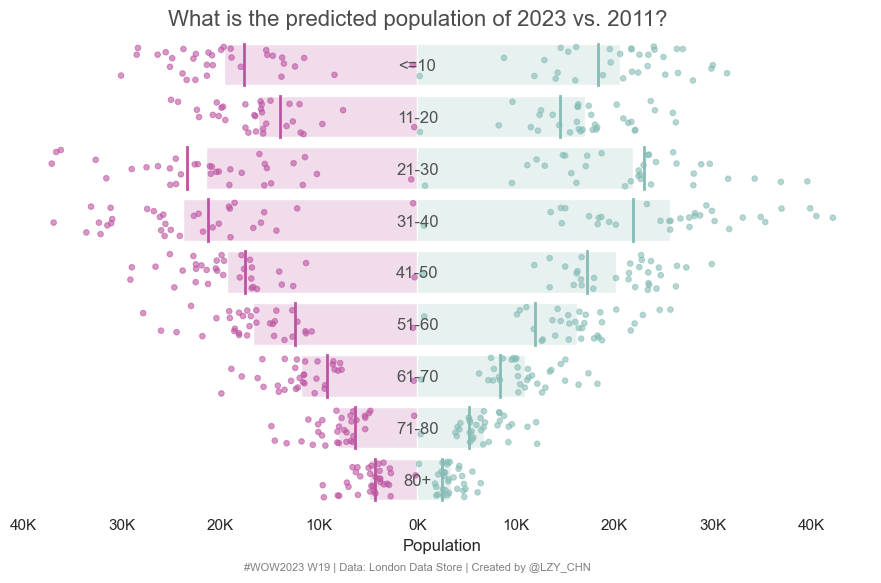

In [44]:
p = (so.Plot(data_joined, x=primary_year, y='age_level', color='gender')
     .add(so.Bar(edgecolor='white', edgewidth=0.5, alpha=0.2), so.Agg(), legend=False)
     .add(so.Dots(fillalpha=0.6, alpha=0.6), so.Jitter(y=0.7, seed=6543321), legend=False)
     .add(so.Range(alpha=1, linewidth=2), orient='v', 
          data=data_joined.groupby(['age_level', 'gender']).mean(numeric_only=True).reset_index(),
          x=secondary_year, 
          ymin=np.arange(-0.4, 8, 1).repeat(2), 
          ymax=np.arange(0.4, 9, 1).repeat(2),
          legend=False, color='gender')
     .add(so.Text(color='#525252'), data=pd.DataFrame({'age_level': data_joined['age_level'].unique()}),
          text='age_level', x=0, y='age_level')
     .add(so.Text(text='What is the predicted population of 2023 vs. 2011?', color='0.3', fontsize=16,
                  offset=25, valign='bottom', artist_kws=dict(clip_on=False)), 
          data={'x':[0], 'y':['<=10']}, x='x', y='y')
     .add(so.Text(text='#WOW2023 W19 | Data: London Data Store | Created by @LZY_CHN', color='0.5', fontsize=8,
                  offset=60, valign='top', artist_kws=dict(clip_on=False)),
          data={'x':[0], 'y':['80+']}, x='x', y='y')
     .scale(color=['#86BCB6', '#BD54A1'], 
            x=so.Continuous().label(like=lambda x, pos: f'{abs(x)/1000:.0f}K'))
     .label(y='', x='Population')
     .layout(size=(9, 6))
     .theme({'axes.spines.left': False, 'axes.spines.right': False, 'axes.spines.top': False, 'axes.spines.bottom': False,
             'axes.grid': False, 'axes.facecolor': 'white', 'ytick.labelleft': False,
     })
)

p.show()

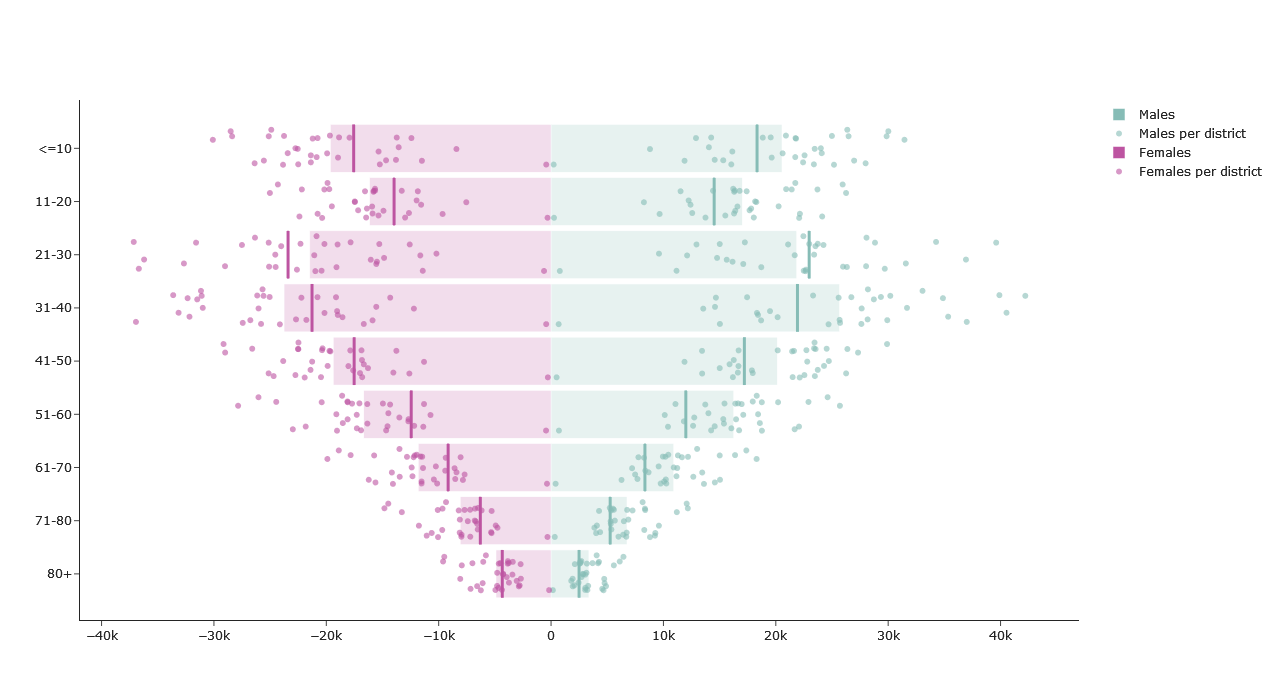

In [110]:
# Another try with plotly
import plotly.graph_objects as go

fig = go.Figure()

colors = {'Males': '#86BCB6',
          'Females': '#BD54A1'}
width=0.9

for gender in genders:    
    # Add some jitter to the age level
    offset = 0.8
    unique_districts = data_selected[f'{gender}'].reset_index()['district'].unique()
    jitter = pd.DataFrame({'district': unique_districts,
                           'jitter': np.random.default_rng(123).uniform(
                               offset*(-width/2), offset*(width/2), len(unique_districts))})
    
    df = data_selected[f'{gender}'].reset_index().merge(jitter, on='district')
    age_level = df['age_level'].unique()
    age_pos = pd.DataFrame({'age_level': age_level,
                            'age_pos': np.arange(0, len(age_level))})
    df = df.merge(age_pos, on='age_level')
    
    # Add bar chart
    ys = np.arange(0, len(data_selected[f'{gender}_avg'].index))
    xs = data_selected[f'{gender}_avg'][primary_year]
    if gender == 'Females':
        xs = -xs
    fig.add_bar(x=xs, y=ys, orientation='h', name=gender, offset=-width/2,
                marker_color=colors[gender], marker_opacity=0.2,
                width=width)
    
    xs = df[primary_year]
    ys = df['age_pos'] + df['jitter']
    if gender == 'Females':
        xs = -xs
    fig.add_scatter(x=xs, y=ys, mode='markers', name=f'{gender} per district',
                    marker_color=colors[gender], marker_opacity=0.6)

    # Add average population for the secondary year
    for ypos in np.arange(0, len(data_selected[f'{gender}_avg'].index)):
        xpos = data_selected[f'{gender}_avg'][secondary_year][ypos]
        if gender == 'Females':
            xpos = -xpos
        fig.add_shape(type='line', xref='x', yref='y',
                      x0=xpos, y0=ypos-width/2,
                      x1=xpos, y1=ypos+width/2,
                      line_color=colors[gender], 
                      line_width=3, opacity=1)  
    
    
fig.update_layout(template='simple_white', width=1200, height=700)
fig.update_yaxes(range=[-0.7, 9], autorange='reversed',
                 ticktext=list(data_selected[f'{gender}_avg'].index), 
                 tickvals=np.arange(0, len(data_selected[f'{gender}_avg'].index)))
fig.show()